In [11]:
#importing stuff
import pandas as pd

df = pd.read_csv("1.0_local_baseline_data.csv")

In [12]:
# Load your preprocessed data (replace with your actual data)
X = df.drop('log_price',axis=1)
y = df['log_price']


In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from hyperopt import fmin, tpe, hp

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function (RMSE)
def objective(params):
    xgb_model = XGBRegressor(objective='reg:squarederror',
                             n_estimators=int(params['n_estimators']),
                             learning_rate=params['learning_rate'],
                             max_depth=int(params['max_depth']),
                             min_child_weight=params['min_child_weight'],
                             subsample=params['subsample'],
                             colsample_bytree=params['colsample_bytree'])
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse

# Define the search space
space = {
    'n_estimators': hp.choice('n_estimators', range(100, 400)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)),
    'max_depth': hp.choice('max_depth', range(3, 12)),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0)
}

# Run Bayesian optimization
best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=1000)

# Update the model with optimized hyperparameters
best_xgb_model = XGBRegressor(objective='reg:squarederror',
                              n_estimators=int(best_params['n_estimators']),
                              learning_rate=best_params['learning_rate'],
                              max_depth=int(best_params['max_depth']),
                              min_child_weight=best_params['min_child_weight'],
                              subsample=best_params['subsample'],
                              colsample_bytree=best_params['colsample_bytree'])
best_xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_xgb_model.predict(X_test)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Optimized Root Mean Squared Error: {rmse:.2f}")

100%|██████████| 1000/1000 [17:04<00:00,  1.02s/trial, best loss: 0.4012607503872044]
Optimized Root Mean Squared Error: 0.41


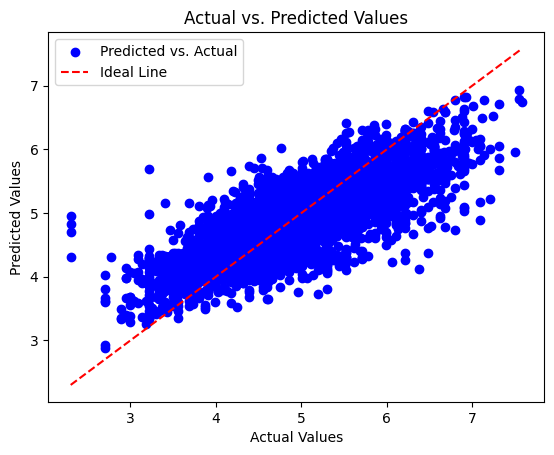

R2: 0.6309
MSE: 0.1673


In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

# Create a scatter plot
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs. Actual')

# Add labels and a title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')

# Add a diagonal line for reference
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Line')

# Show the legend
plt.legend()

# Show the plot
plt.show()

# Calculate R2
r2 = r2_score(y_test, y_pred)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)

print(f"R2: {r2:.4f}")
print(f"MSE: {mse:.4f}")